In [26]:
import sys, os
import autorootcwd

import src.data.data_loader as module_data
import src.model.metric as module_metric
import src.model.model as module_arch
from src.model.model import compute_similarity
from src.trainer.trainer import verbose
from src.utils.util import state_dict_data_parallel_fix

import argparse

import pandas as pd
import torch
import transformers
from sacred import Experiment
from tqdm import tqdm
import glob

import numpy as np
import os
import copy
import pathlib
import platform

In [27]:
# 데이터 직접 조회하기
from src.data.NTU_dataset import NTU
from src.data.transforms import init_transform_dict
tsfm_params = {}
tsfm_dict = init_transform_dict(**tsfm_params)

ntu_dataset = NTU(
    dataset_name='NTU',
    text_params={'input': 'text'}, 
    video_params={
    'extraction_fps': 25,
    'extraction_res': 256,
    'input_res': 224,
    'num_frames': 4,
    'stride': 1
},
    data_dir='data/nturgbd',
    metadata_dir='data/nturgbd',
    split='test',
    tsfms=tsfm_dict['test'],
    cut='standard',
    subsample=1, # 1은 모든 데이터를 사용한다는 의미
    sliding_window_stride=-1,
    reader='decord'
)

print(ntu_dataset)
print(f"dataset size: {len(ntu_dataset)}")
print(f"metadata shape: {ntu_dataset.metadata.shape}")
print(f"first video id: {ntu_dataset.metadata.index[0]}")
print(f"dataset_name: {ntu_dataset.dataset_name}")
print(f"split: {ntu_dataset.split}")
print(f"data directory: {ntu_dataset.data_dir}")
print(f"metadata directory: {ntu_dataset.metadata_dir}")

sample = ntu_dataset[0]
print(sample["video"].shape, sample["text"], sample["meta"])

dataset size: 600
metadata shape: (600, 3)
first video id: S017C001P008R001A001_rgb
dataset_name: NTU
split: test
data directory: data/nturgbd
metadata directory: data/nturgbd
torch.Size([4, 3, 224, 224]) drink_water {'raw_captions': 'drink_water', 'paths': 'video\\A1_drink_water/S017C001P008R001A001_rgb.mp4', 'dataset': 'NTU'}


비디오 ID: S017C001P008R001A023_rgb
캡션: hand_waving
torch.Size([4, 3, 224, 224])


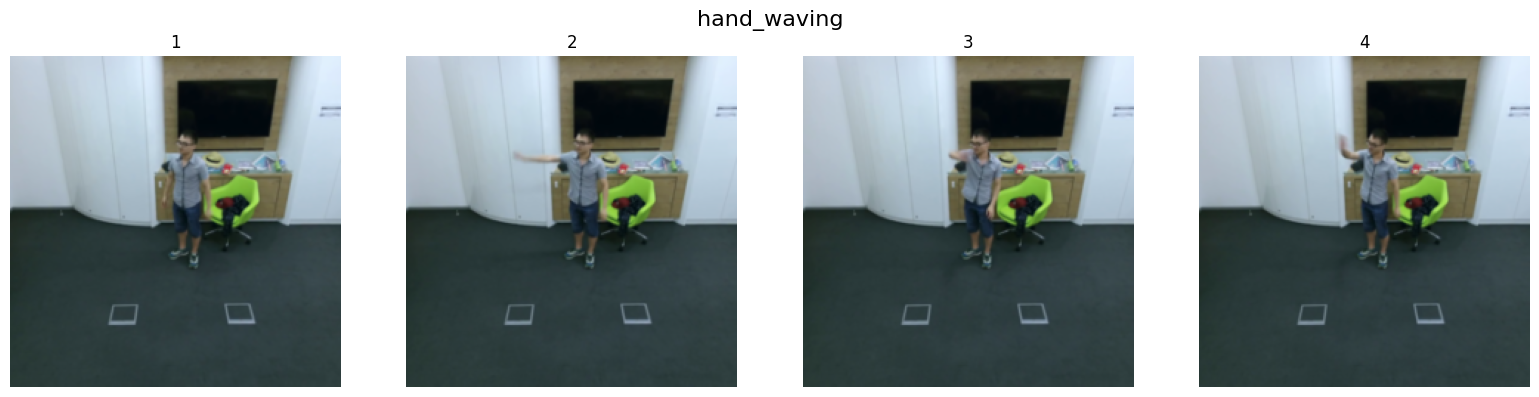

In [28]:
import matplotlib.pyplot as plt

idx = 220
sample = ntu_dataset[idx]

print(f"비디오 ID: {ntu_dataset.metadata.index[idx]}")
print(f"캡션: {sample['text']}")

video = sample['video']
print(video.shape)
num_frames = video.shape[0]

fig, axes = plt.subplots(1, num_frames, figsize=(16, 4))
if num_frames == 1:
    axes = [axes]

for i in range(num_frames):
    frame = video[i].permute(1, 2, 0).numpy()
    if frame.min() < 0 or frame.max() > 1:
        frame = (frame - frame.min()) / (frame.max() - frame.min())
        
    axes[i].imshow(frame)
    axes[i].set_title(f"{i+1}")
    axes[i].axis('off')
    
plt.suptitle(f"{sample['text']}", fontsize=16)
plt.tight_layout()
plt.show()

In [29]:
ntu_metadata_dir = "data/nturgbd"
csv_fp = os.path.join(ntu_metadata_dir, 'annotations.csv')
ntu_df = pd.read_csv(csv_fp)

ntu_split_dir = os.path.join(ntu_metadata_dir, 'splits')
ntu_train_list_path = "train_list.txt"
ntu_test_list_path = "test_list.txt"

        
ntu_train_df = pd.read_csv(os.path.join(ntu_split_dir, ntu_train_list_path), names=['videoid'])
ntu_test_df = pd.read_csv(os.path.join(ntu_split_dir, ntu_test_list_path), names=['videoid'])

print(ntu_train_df.head())
print(ntu_test_df.head())

ntu_metadata = ntu_df.groupby(['video_id'])['caption'].apply(list)
print(ntu_metadata.head())

                    videoid
0  S017C001P003R001A001_rgb
1  S017C001P003R001A002_rgb
2  S017C001P003R001A003_rgb
3  S017C001P003R001A004_rgb
4  S017C001P003R001A005_rgb
                    videoid
0  S017C001P008R001A001_rgb
1  S017C001P008R001A002_rgb
2  S017C001P008R001A003_rgb
3  S017C001P008R001A004_rgb
4  S017C001P008R001A005_rgb
video_id
S017C001P003R001A001_rgb    [drink_water]
S017C001P003R001A002_rgb       [eat_meal]
S017C001P003R001A003_rgb    [brush_teeth]
S017C001P003R001A004_rgb     [brush_hair]
S017C001P003R001A005_rgb           [drop]
Name: caption, dtype: object


In [30]:
tsfm_params = {}
tsfm_dict = init_transform_dict(**tsfm_params)

print("변환함수 종류: ", tsfm_dict.keys())

print("테스트 변환 함수 단계: ", tsfm_dict['test'])

변환함수 종류:  dict_keys(['train', 'val', 'test'])
테스트 변환 함수 단계:  Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


video_path: data/nturgbd\video\A1_drink_water/S017C001P008R001A001_rgb.mp4


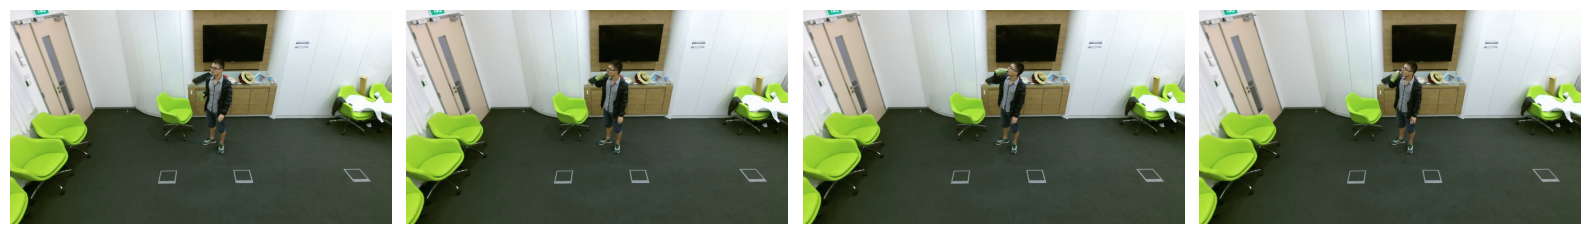

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.data.base_dataset import read_frames_decord, sample_frames

idx = 0
sample_metadata = ntu_dataset.metadata.iloc[idx]
video_path, _ = ntu_dataset._get_video_path(sample_metadata)
print(f"video_path: {video_path}")

frames, frames_idx = read_frames_decord(video_path, 4, sample='uniform')

fig, axes = plt.subplots(1, len(frames), figsize=(16, 4))
for i, frame in enumerate(frames):
    # 텐서를 이미지로 변환 (C,H,W) -> (H,W,C)
    img = frame.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [32]:
print("변환 전!")
print(f"프레임 shape: {frames.shape}")
print(f"픽셀값 범위: [{frames.min():.2f}, {frames.max():.2f}]")

print("\n변환 후!")
transformed_frames = tsfm_dict['test'](frames)
print(f"프레임 shape: {transformed_frames.shape}")
print(f"픽셀값 범위: [{transformed_frames.min():.2f}, {transformed_frames.max():.2f}]")


변환 전!
프레임 shape: torch.Size([4, 3, 1080, 1920])
픽셀값 범위: [0.00, 1.00]

변환 후!
프레임 shape: torch.Size([4, 3, 224, 224])
픽셀값 범위: [-2.05, 2.64]


In [33]:
from src.data.data_loader import TextVideoDataLoader

module_args = {
    'dataset_name': 'NTU',
    'data_dir': 'data/nturgbd',
    'shuffle': False,
    'num_workers': 16,
    'batch_size': 16,
    'split': 'test',
    'cut': 'standard',
    'subsample': 1,
    'text_params': {'input': 'text'},
    'video_params': {
        'extraction_fps': 25,
        'extraction_res': 256,
        'input_res': 224,
        'num_frames': 4,
        'stride': 1
    },
    'tsfm_split': 'test',
    'sliding_window_stride': -1
}

data_loader = TextVideoDataLoader(**module_args)

In [34]:
first_batch = next(iter(data_loader))

In [35]:
dataset = data_loader.dataset
print(f"Metadata shape: {dataset.metadata.shape}")
print(f"Metadata 첫 3행:\n{dataset.metadata.head(3)}")

Metadata shape: (600, 3)
Metadata 첫 3행:
                              caption  \
video_id                                
S017C001P008R001A001_rgb  drink_water   
S017C001P017R001A001_rgb  drink_water   
S017C002P007R002A001_rgb  drink_water   

                                                           video_path  \
video_id                                                                
S017C001P008R001A001_rgb  A1_drink_water/S017C001P008R001A001_rgb.mp4   
S017C001P017R001A001_rgb  A1_drink_water/S017C001P017R001A001_rgb.mp4   
S017C002P007R002A001_rgb  A1_drink_water/S017C002P007R002A001_rgb.mp4   

                               captions  
video_id                                 
S017C001P008R001A001_rgb  [drink_water]  
S017C001P017R001A001_rgb  [drink_water]  
S017C002P007R002A001_rgb  [drink_water]  


In [9]:
text_model_name = 'distilbert-base-uncased'
print(f"Text model: {text_model_name}")

if "openai/clip" in text_model_name:
    tokenizer_builder = transformers.CLIPTokenizer
else:
    tokenizer_builder = transformers.AutoTokenizer
tokenizer = tokenizer_builder.from_pretrained(
    text_model_name,
    model_max_length=int(1e6),
    TOKENIZERS_PARALLELISM=False
)

Text model: distilbert-base-uncased


In [10]:
import copy

data = copy.deepcopy(first_batch)

if tokenizer is not None:
    print(f"원본 텍스트: {data['text'][:2]}")
    data['text'] = tokenizer(data['text'], return_tensors='pt', padding=True, truncation=True)
    print(f"토큰화 후 키들:{data['text'].keys()}")
    print(f"Input IDs shape: {data['text']['input_ids'].shape}")

원본 텍스트: ['drink_water', 'drink_water']
토큰화 후 키들:KeysView({'input_ids': tensor([[ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4392, 1035, 2300,  102],
        [ 101, 4521, 1035, 7954,  102],
        [ 101, 4521, 1035, 7954,  102],
        [ 101, 4521, 1035, 7954,  102],
        [ 101, 4521, 1035, 7954,  102],
        [ 101, 4521, 1035, 7954,  102],
        [ 101, 4521, 1035, 7954,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1